In [8]:
# %pip install linearmodels
# Install last version of Pandas:
%pip install --upgrade pandas
# %pip install plotnine
# Run in the virtual environment:
# source envkkr/bin/activate
# %pip install numba

^C
Traceback (most recent call last):
  File "/Users/pedrovallocci/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/pedrovallocci/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/pedrovallocci/Documents/PhD (local)/Research/Github/KnowledgeKRisk_10Ks/src/envkkr/lib/python3.9/site-packages/pip/__main__.py", line 22, in <module>
    from pip._internal.cli.main import main as _main
  File "/Users/pedrovallocci/Documents/PhD (local)/Research/Github/KnowledgeKRisk_10Ks/src/envkkr/lib/python3.9/site-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/Users/pedrovallocci/Documents/PhD (local)/Research/Github/KnowledgeKRisk_10Ks/src/envkkr/lib/python3.9/site-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_mai

Embeddings loaded from data/embeddings.pkl


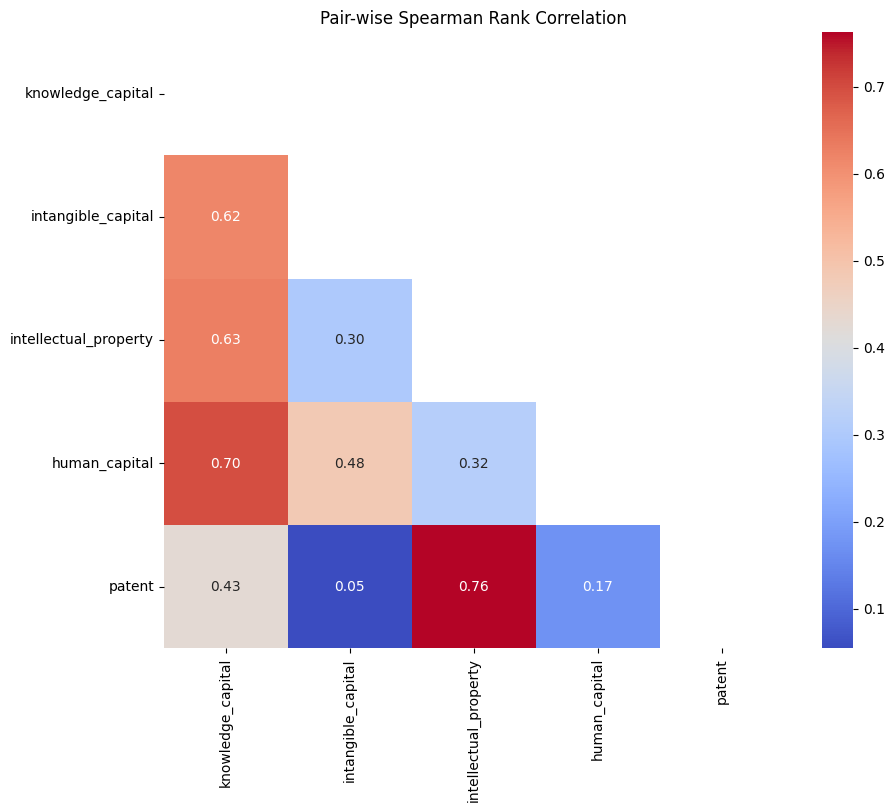

In [1]:
# # Example usage
# models = {
#     'knocap': knocap,
#     'intcap': intcap,
#     'ip': ip,
#     'humcap': humcap,
#     'patents': patents
# }
import embedding_tools as et
embeddings = et.Embeddings()
# terms = ['topic_kk']
et.plot_spearman_correlation(embeddings, ["knowledge capital", "intangible capital", "intellectual property", "human capital", "patent"])

In [16]:
# Require Pandas version >= 2.2.2
import pandas as pd
#pd.__version__
assert pd.__version__ >= '2.2.2', 'Please update Pandas to version 2.2.2 or newer'
import linearmodels
import pandas as pd, os, pyreadr
import warnings
import time
import numpy as  np
import pandas as pd
import random
import pandas as pd
import visualization as viz
import data_loading as dl
import risk_pricing as rp
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import importlib
importlib.reload(rp)
importlib.reload(viz)
importlib.reload(dl)
#print(pd.__version__)
#% PARAMETERS
source_folder_path = "/Users/pedrovallocci/Documents/PhD (local)/Research/Github/KnowledgeKRisk_10Ks/src/"
modelname = "embeddings_km10_ipcs" # "dicfullmc10thr10defnob40noa0_8_hdp" # Don't forget to clean again when modelname changes
quantiles = 4
generate_plots = True
warnings.filterwarnings("ignore")
print_kurtosis = False
pfn = "pf36_name"
mo_window = 12*5
start_time = time.time()
# print the current working directory (for reference)
print("Current Working Directory:", os.getcwd())
os.chdir(source_folder_path)
print("New Working Directory:", os.getcwd())
# Creating the directory
base_path = "/Users/pedrovallocci/Documents/PhD (local)/Research/Github/KnowledgeKRisk_10Ks/text/"
dir_path = os.path.join(base_path, modelname + "_py")
os.makedirs(dir_path, exist_ok=True)

# Setting up the figure folder path
figfolder = os.path.join(dir_path, "")


Current Working Directory: /Users/pedrovallocci/Documents/PhD (local)/Research/Github/KnowledgeKRisk_10Ks/src
New Working Directory: /Users/pedrovallocci/Documents/PhD (local)/Research/Github/KnowledgeKRisk_10Ks/src


In [17]:
# Loading the data from load_dataframes:
amazon_nov01_short, cequity_mapper, ff3fw, ff5fw, ff3fm, ff5fm, \
    topic_map_unlabeled, comparison_measures, stoxmo_orig,\
    stoxda_orig, stoxwe_orig = \
    dl.load_dataframes(modelname, start_time, clean_again = True)


Tempo de execução: 58.994734048843384
Tempo de execução: 65.17876815795898
Tempo de execução: 65.23374629020691
Tempo de execução: 65.33192610740662
Tempo de execução: 65.49696111679077
Tempo de execução: 149.65917205810547


In [18]:
topic_map_unlabeled.head()

,max_topic,topic_kk,year,CIK,CUSIP8,LPERMNO,sic,cik,gvkey,conm,...,at,prcc_f,prcc_c,ppegt,csho,ceq,cusip,exchg,xir_cumsum,xir_total
0,6,0.229141,2006,1750,00036110,54594.0,5080.0,1750.0,1004.0,AAR CORP,...,1067.633,32.50,29.19,405.685,37.729,494.243,000361105,11.0,0.000000,0.000000
1,6,0.216411,2007,1750,00036110,54594.0,5080.0,1750.0,1004.0,AAR CORP,...,1362.010,19.28,38.03,476.463,38.773,585.255,000361105,11.0,0.000000,0.000000
2,6,0.204073,2009,1750,00036110,54594.0,5080.0,1750.0,1004.0,AAR CORP,...,1501.042,19.70,22.98,528.569,39.484,746.906,000361105,11.0,0.021185,0.002789
3,6,0.217021,2010,1750,00036110,54594.0,5080.0,1750.0,1004.0,AAR CORP,...,1703.727,26.39,27.47,652.862,39.781,835.845,000361105,11.0,0.024258,0.005593
4,6,0.214188,2011,1750,00036110,54594.0,5080.0,1750.0,1004.0,AAR CORP,...,2195.653,12.05,19.17,754.451,40.273,864.649,000361105,11.0,0.019856,0.001033


In [19]:
# Pause execution of code and return to the command line:
importlib.reload(viz)
# if modelname == "embeddings_km10":
#     topic_map_unlabeled["ntile_kk"] = 0
#     topic_map_unlabeled["topic_kk"] = 0
#     topic_map_unlabeled.loc[topic_map_unlabeled["max_topic"] == 3, "ntile_kk"] = 1
#     topic_map_unlabeled.loc[topic_map_unlabeled["max_topic"] == 3, "topic_kk"] = 1
#     topic_map = topic_map_unlabeled
# else:
#     topic_map = viz.label_topic_map(topic_map_unlabeled, modelname, cuts = [0, 0.33, 0.67, 1])
topic_map = viz.label_topic_map(topic_map_unlabeled, modelname, cuts = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
modelname = modelname + "_deciles"

In [20]:
import risk_pricing as rp
import importlib
importlib.reload(rp)
pfname = "pfkki3me3mb" #'pfkk3me3mb', 'pf2me3mb', 'pf5me5mb', 'pfkk2me3mb', 'pfkki3me3mb'
fmb_3, indexed_df, eret_we, stoxwe_add = rp.famaMacBethFull(stoxwe_orig, cequity_mapper, topic_map, ff3fw, pfname, window_size = 52*2, add_innerkk_pf = True)
fmb_5, indexed_df, eret_we, stoxwe_add = rp.famaMacBethFull(stoxwe_orig, cequity_mapper, topic_map, ff5fw, pfname, window_size = 52*2, add_innerkk_pf = True)
fmb_3.summary

Agora com mudança no kki
Agora com mudança no kki


Dep. Variable:,eretw,R-squared:,0.0028
Estimator:,FamaMacBeth,R-squared (Between):,0.8864
No. Observations:,29430,R-squared (Within):,-0.0004
Date:,"Sun, Jun 23 2024",R-squared (Overall):,0.0028
Time:,13:22:57,Log-likelihood,5.497e+04
Cov. Estimator:,Fama-MacBeth Kernel Cov,,
,,F-statistic:,20.966
Entities:,45,P-value,0.0000
Avg Obs:,654.00,Distribution:,"F(4,29426)"
Min Obs:,654.00,,
Max Obs:,654.00,F-statistic (robust):,5.7983


Variables created:

- amazon_nov01_short:

- cequity_mapper:

- Fama-French factors: ff3fw, ff5fw, ff3fm, ff5fm

- Topic_map_unlabeled

- Stocks vectors: stoxmo_orig, stoxwe_orig

- comparison_measures: a vector that calculates the average industry skill and firm patent intensity for each of the topics.

In [10]:
import visualization as viz
import importlib
importlib.reload(viz)
#import visualization as viz
viz.explore_topic_map(topic_map, figfolder, generate_plots)
viz.explore_fmb(fmb_3, fmb_5, figfolder)
viz.explore_eret_we(eret_we, figfolder)
viz.tex_compare_kk_measures(comparison_measures, figfolder)
viz.plot_returns(stoxwe_add, figfolder)
viz.amazon_graph(amazon_nov01_short, figfolder)
viz.filecounter(figfolder)
viz.explore_stoxda(stoxda_orig, cequity_mapper, topic_map, figfolder)

Executing fig_mean_tiy...
Executing tex_average_topic_loadings_by_high_tech...
Executing tex_sample_topic_loadings...
Executing df_skill_correlations...
Executing df_patent_correlations...
Executing fig_share_dominant_kk_by_ind...
Executing fig_heatmap_topicvskkpt...
Executing fig_heatmap_topicvsikpt...
Executing fig_histogram_kk...
Executing fig_histogram_kk_by_ind12...
Finished!
Executing explore_fmb...
Executing tex_summary...
Executing fig_h1b_vs_smb_kkhml...
Executing tex_HKR_vs_mktrf...
Executing tex_compare_kk_measures...
Executing plot_returns...
Executing amazon_graph...
Executing filecounter...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>